## Домашнее задание 2
* Обучить полносвязную модель на MNIST
* Обучить глубокую сверточную сеть на MNIST
* *обучить с нуля глубокую сеть на небольшом датасете. Сравнить результат с дообучением предобученной модели

Материалы занятия: https://github.com/BorisZH/reload_NN5/tree/master/lesson2, блокнот скопирован в lesson_02

In [2]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

* архитектура модели + 
* загрузчик данных +
* формирование батча +
* инициализировать модель +
* оптимизатор +
* функция потерь +
* опционально шедулеры -
* трейн луп

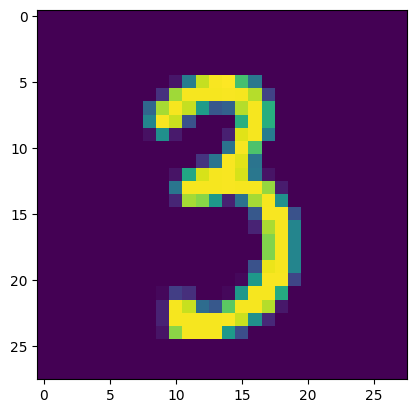

In [5]:
dataset = datasets.MNIST('.', download=True)
plt.imshow(dataset.data[98].detach().numpy())
print(dataset.te)
plt.show()

In [9]:
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
len_train = len(train_set)
len_validate = len(val_set)
len_all = len(dataset)
print(f'Train set size: {len_train}, validate set size: {len_validate}, whole dataset size: {len_all}')

Train set size: 50000, validate set size: 10000, whole dataset size: 60000
